In [160]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [117]:
df = pd.DataFrame(columns=['text', 'length','punctuation_ratio', 'spam'])

with open(r'.\SMSSpamCorpus01\english_big.txt', encoding='utf-8') as f:
    t = f.readlines()
for i, raw_row in enumerate(t):
    raw_row = raw_row.split(',')
    text = ''.join(raw_row[:-1])
    df.loc[i] = [text, len(text), len(list(filter(lambda x: x in string.punctuation, text)))/len(text), raw_row[-1].strip() == 'spam']

In [118]:
df.head()

text length  \
0  Urgent! call 09061749602 from Landline. Your c...    147   
1  +449071512431 URGENT! This is the 2nd attempt ...    161   
2  FREE for 1st week! No1 Nokia tone 4 ur mob eve...    158   
3  Urgent! call 09066612661 from landline. Your c...    166   
4  WINNER!! As a valued network customer you have...    157   

   punctuation_ratio  spam  
0           0.040816  True  
1           0.055901  True  
2           0.037975  True  
3           0.042169  True  
4           0.044586  True

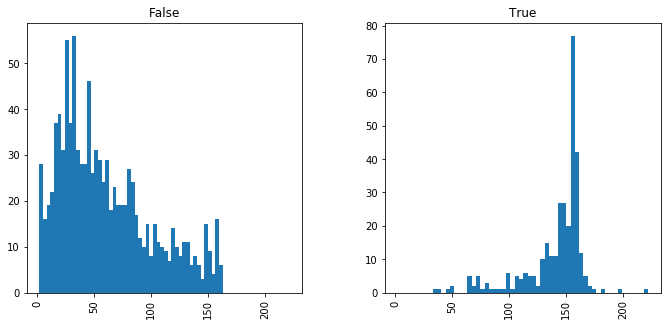

In [119]:
df.hist(column='length', by='spam', bins=50, figsize=(11,5), sharex=True);
# интересно, что спам длиннее 

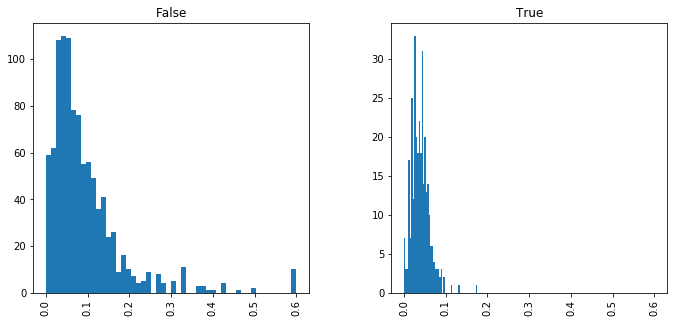

In [120]:
df.hist(column='punctuation_ratio', by='spam', bins=50, figsize=(11, 5), sharex=True);
# этот признак визуально ничего не дает

In [121]:
# поэтому все знаки препинания можно спокойно удалить
df.drop('punctuation_ratio', axis=1, inplace=True)

In [122]:
df['purified_text'] = df['text'].apply(lambda x:''.join(x for x in x if x not in string.punctuation))

In [123]:
df['caps_ratio'] = df['text'].apply(lambda x:len(set(x).intersection(string.ascii_uppercase))/len(x))

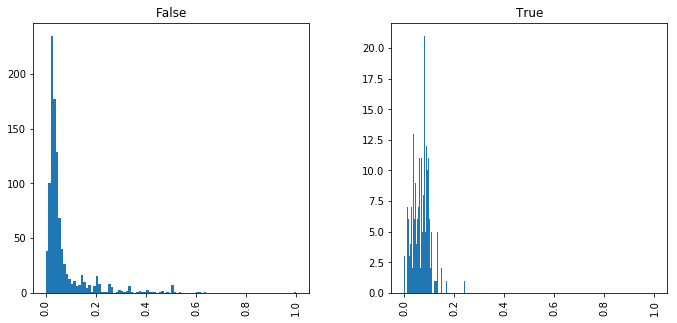

In [124]:
df.hist(column='caps_ratio', by='spam', bins=100, figsize=(11, 5), sharex=True);
# и этот признак не важен 

In [125]:
df.drop('caps_ratio', axis=1, inplace=True)

In [126]:
df['purified_text'] = df['purified_text'].apply(lambda x: ''.join(x for x in x.lower() if x not in string.digits))
df['digits_ratio'] = df['text'].apply(lambda x:len(set(x).intersection(string.digits))/len(x))

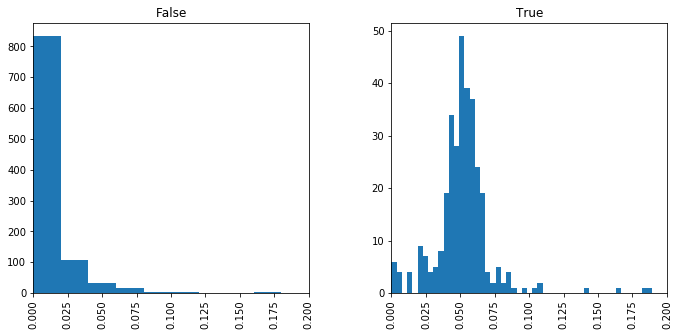

In [127]:
df.hist(column='digits_ratio', by='spam', bins=50, figsize=(11, 5), sharex=True);
plt.xlim((0, 0.2));
# а это, кожется, что-то значит

In [138]:
def del_stopwords(text):
    return ' '.join(word for word in text.strip().split() if word not in stopwords.words('english'))

def purify_text(text):
    text= ''.join(t for t in text.lower() if t not in string.punctuation and t not in string.digits)
    return del_stopwords(text)

In [139]:
df['purified_text'] = df['purified_text'].apply(del_stopwords)

In [201]:
vectorizer = TfidfVectorizer("english", max_features=3000)
features = vectorizer.fit_transform(df['purified_text'])

In [202]:
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()

features_train, features_test, labels_train, labels_test = train_test_split(features, df['spam'].astype(int), test_size=0.1)


params = {'alpha':np.arange(0, 1, 0.05)}
mnbgrid = GridSearchCV(mnb, params, cv=100)
bnbgrid = GridSearchCV(bnb, params, cv=100)
gnbgrid = GridSearchCV(gnb, {}, cv=100)
mnbgrid.fit(features_train, labels_train)
gnbgrid.fit(features_train.toarray(), labels_train)
bnbgrid.fit(features_train, labels_train);

In [203]:
print(classification_report(mnbgrid.predict(features_test), labels_test))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       107
          1       0.89      0.96      0.93        26

avg / total       0.97      0.97      0.97       133



In [204]:
print(classification_report(gnbgrid.predict(features_test.toarray()), labels_test))

             precision    recall  f1-score   support

          0       0.87      0.98      0.92        93
          1       0.93      0.65      0.76        40

avg / total       0.89      0.88      0.87       133



In [205]:
print(classification_report(bnbgrid.predict(features_test), labels_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       105
          1       1.00      1.00      1.00        28

avg / total       1.00      1.00      1.00       133



In [195]:
# загрузим еще один найденный в сети датасет, посмотрим, какие на нем будут результаты
test_data = pd.read_csv(r'./sms-spam-collection-dataset/spam.csv', encoding='latin-1')
test_data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1, inplace=True)
test_data['v1'] = test_data['v1'] == 'spam'
test_data['text'] = test_data['v2'].apply(purify_text)
test_data.drop('v2', inplace=True, axis=1)
test_data.head()

v1                                               text
0  False  go jurong point crazy available bugis n great ...
1  False                            ok lar joking wif u oni
2   True  free entry wkly comp win fa cup final tkts st ...
3  False                u dun say early hor u c already say
4  False        nah dont think goes usf lives around though

In [206]:
test_data.shape

(5572, 2)

In [207]:
features = vectorizer.fit_transform(test_data['text'])
print(classification_report(bnbgrid.predict(features), test_data['v1'].astype(int)))

ValueError: Expected input with 2985 features, got 3000 instead